## Importing Libraries

In [1]:
import json, requests, urllib
from pathlib import Path
import pandas as pd
import numpy as np
import missingno as msno

## Variables

In [2]:
# Defining the countries in list
countries_list = ["India", "Brazil", "Iran", "United States"]
# Setting pandas dataframe precision to 2
pd.set_option("precision", 2)
# Setting up country colors
country_colors = {
    "India": "green",
    "Brazil": "darkred",
    "Iran": "navy",
    "United States": "red",
}
# Setting up font size
fontsize = 13

In [3]:
# creating folder structure for raw data
dir_raw = Path("raw")
dir_raw.mkdir(parents=True, exist_ok=True)
# creating folder structure for clean data
dir_data = Path("data")
dir_data.mkdir(parents=True, exist_ok=True)

In [4]:
# defining api key
f = open("apikey.txt", "r")
api_key = f.read()
# defining api url
api_prefix = " https://www.numbeo.com/api"

## Fetching Data

In [5]:
def fetch(endpoint, params={}):
    # construct the url
    url = api_prefix
    if not endpoint.startswith("/"):
        url += "/"
    url += endpoint
    (api_prefix, endpoint)

    ke = {"api_key": api_key}
    url += f"?{urllib.parse.urlencode(ke)}"
    if params:
        url += f"&{urllib.parse.urlencode(params)}"
    print(f"Fetching {url}")
    # fetch the page
    response = requests.get(url)
    jdata = response.text
    return json.loads(jdata)

In [6]:
def fetch_all(section):
    # create the endpoint URL
    endpoint = "/rankings_by_country_historical"
    # fetch the current data
    params = {"section": section}
    conditions_data = fetch(endpoint, params)
    # write it out to our raw dataset directory
    fname = f"data_{section}.json"
    out_path = dir_raw / fname
    print(f"Writing data to {out_path}")
    with open(out_path, "w") as fout:
        json.dump(conditions_data, fout, indent=4, sort_keys=True)

In [7]:
# defining section for api
sections = [12]
for section in sections:
    fetch_all(section)

Fetching  https://www.numbeo.com/api/rankings_by_country_historical?api_key=u2hnidtpefviua&section=12
Writing data to raw\data_12.json


## Parsing Data

In [8]:
def parse_raw_data(country, section):
    fname = f"data_{section}.json"
    fpath = dir_raw / fname
    with open(fpath, "r") as fin:
        jdata = fin.read()
        data = json.loads(jdata)

        all_data = []
        for year in data:
            if year.isnumeric():
                for countries in data[year]:
                    if countries["country"] == country and section == 12:
                        res = dict(
                            year=year,
                            country=countries["country"],
                            traffic_time_index=countries["traffic_time_index"],
                            quality_of_life_index=countries["quality_of_life_index"],
                            healthcare_index=countries["healthcare_index"],
                            purchasing_power_incl_rent_index=countries[
                                "purchasing_power_incl_rent_index"
                            ],
                            house_price_to_income_ratio=countries[
                                "house_price_to_income_ratio"
                            ],
                            pollution_index=countries["pollution_index"],
                            safety_index=countries["safety_index"],
                            cpi_index=countries["cpi_index"],
                        )
                        all_data.append(res)
    return pd.DataFrame(all_data)


def parse_merge_raw_data(country, section):
    df_files = []
    return parse_raw_data(country, section)


import itertools
df_countries = {}
for section, country in itertools.product(sections, countries_list):
    df_country = parse_merge_raw_data(country, section)
    df_countries[country] = df_country

In [9]:
# creating a full dataframe
import itertools
full_df = []
for section, country in itertools.product(sections, countries_list):
    df_country = parse_raw_data(country, section)
    full_df.append(df_country)
full = pd.concat(full_df)
full.index = np.arange(1, len(full) + 1)

In [10]:
df_countries.keys()

dict_keys(['India', 'Brazil', 'Iran', 'United States'])

In [11]:
df_countries["India"]

,year,country,traffic_time_index,quality_of_life_index,healthcare_index,purchasing_power_incl_rent_index,house_price_to_income_ratio,pollution_index,safety_index,cpi_index
0,2014,India,47.72,78.01,64.62,62.33,10.16,74.34,56.30,26.70
1,2015,India,45.24,78.60,66.86,65.79,10.06,77.72,53.45,26.27
2,2016,India,45.98,109.28,66.47,89.65,10.54,77.02,53.41,24.14
3,2017,India,46.38,101.52,69.18,76.73,10.28,76.53,56.04,25.08
4,2018,India,46.76,122.09,67.39,79.27,9.73,75.89,55.84,26.88
5,2019,India,45.71,117.51,68.32,66.91,11.33,75.81,57.28,24.17
6,2020,India,46.99,108.63,67.13,54.30,11.38,78.87,56.68,24.58
7,2021,India,46.66,104.52,66.25,47.13,11.31,79.62,55.28,25.16
8,2022,India,46.52,110.99,65.66,49.72,10.16,73.05,55.37,24.43


## Check missing val

In [12]:
for country in countries_list:
    print(f"-- {country}")
    missing_counts = df_countries[country].isnull().sum()
    # which coludmns have missing values?
    missing_counts = missing_counts[missing_counts > 0]
    if len(missing_counts) == 0:
        print("No missing values found")
    else:
        print(missing_counts)

-- India
No missing values found
-- Brazil
No missing values found
-- Iran
No missing values found
-- United States
No missing values found


In [13]:
# checking null data for full dataset
full.isnull().sum()

year                                0
country                             0
traffic_time_index                  0
quality_of_life_index               0
healthcare_index                    0
purchasing_power_incl_rent_index    0
house_price_to_income_ratio         0
pollution_index                     0
safety_index                        0
cpi_index                           0
dtype: int64

<AxesSubplot:>

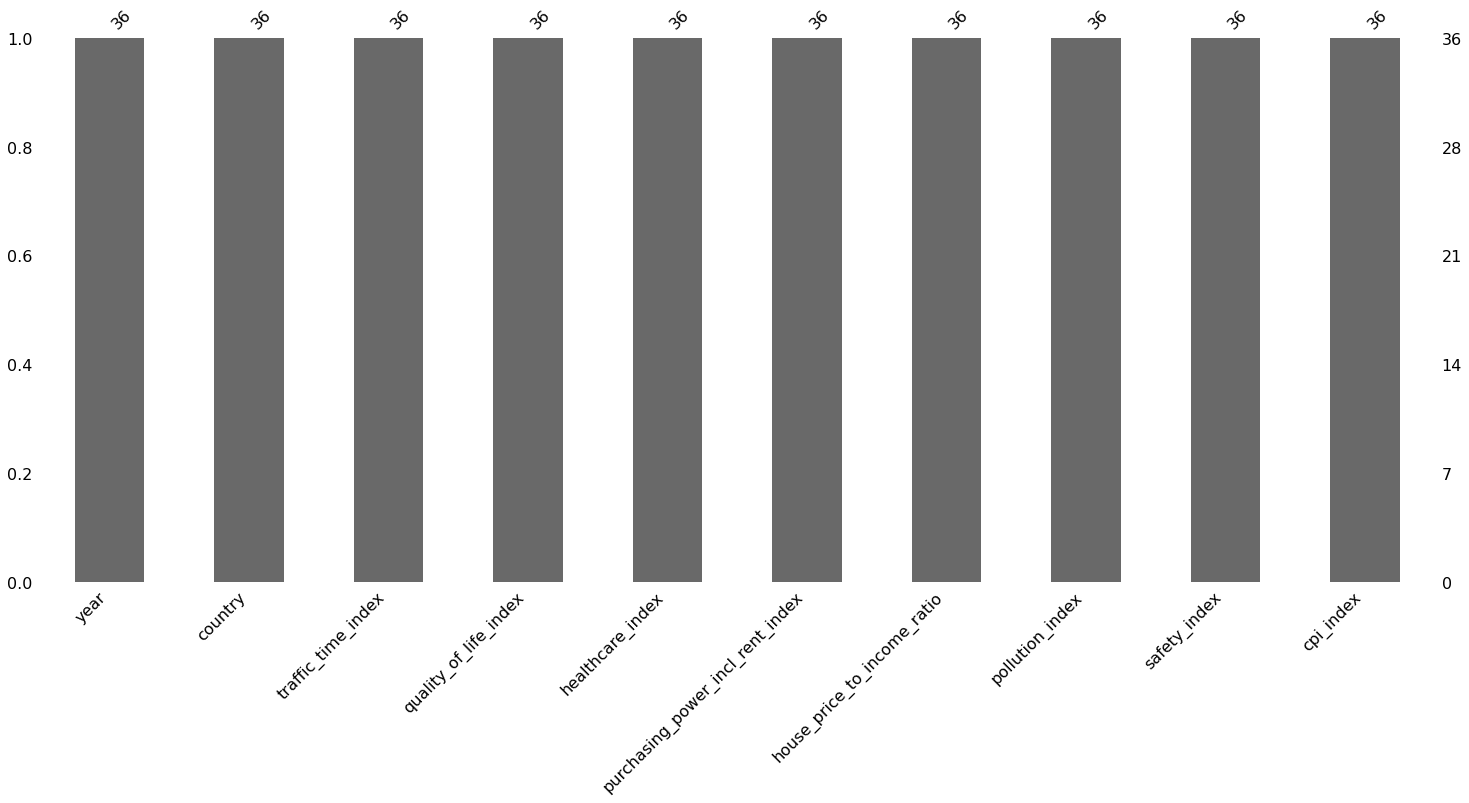

In [14]:
msno.bar(full)

## Data Saving

In [15]:
for country in countries_list:
    fname = f"{country}.json"
    out_path = dir_data / fname
    print(f"Writing {out_path}")
    df_countries[country].to_json(out_path, orient="index", indent=4)

Writing data\India.json
Writing data\Brazil.json
Writing data\Iran.json
Writing data\United States.json


In [16]:
# saving the full dataset
path = f"{dir_data}\\full.json"
full.to_json(path, orient="index", indent=4)
print(f"Writing {path}")

Writing data\full.json
